<a href="https://colab.research.google.com/github/JorgeGuiller/MachineLearning/blob/main/hw4_gonzales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github link: https://github.com/JorgeGuiller/MachineLearning/blob/main/hw4_gonzales.ipynb

In [ ]:
import os
from email import policy
from email.parser import BytesParser
from concurrent.futures import ProcessPoolExecutor
from email.errors import MessageParseError
from collections import Counter
from email.policy import default
import matplotlib.pyplot as plt
import numpy as np
import re

# Load stop words from a file
def load_stop_words(stop_words_file):
    with open(stop_words_file, 'r') as file:
        stop_words = set(file.read().split())
    return stop_words

# Preprocess email content (remove alphanumeric characters, punctuation, and stop words)
def preprocess_email_content(content, stop_words):
    content = content.lower()
    content = re.sub(r'[^a-z\s]', '', content)  # Remove punctuation, non-alphabetic characters
    words = content.split()  # Split into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return words

# Load and decode the email content
def load_email(filepath):
    try:
        with open(filepath, 'rb') as file:
            email = BytesParser(policy=policy.default).parse(file)
            if email:
                return extract_email_content(email)
            else:
                print(f"Warning: No content found in email: {filepath}")
                return ""
    except (MessageParseError, UnicodeDecodeError) as e:
        print(f"Error parsing email at {filepath}: {e}")
        return ""

# Extract content from a MIME email message
def extract_email_content(email):
    content = []
    if email.is_multipart():
        for part in email.iter_parts():
            if part.get_content_disposition() == 'attachment':
                continue  # Skip attachments
            content.append(decode_part_content(part))
    else:
        content.append(decode_part_content(email))
    return "\n".join(content)

# Decode part content with error handling and multiple charset fallbacks
def decode_part_content(part):
    try:
        # Attempt to decode using the declared charset
        charset = part.get_content_charset(failobj='utf-8')
        part_content = part.get_payload(decode=True)
        if part_content:
            return part_content.decode(charset, errors='replace')
        else:
            return ""
    except (UnicodeDecodeError, LookupError):
        # Fallback decoding using common encodings if declared charset fails
        part_content = part.get_payload(decode=True)
        if part_content:
            for charset in ['utf-8', 'latin-1', 'iso-8859-1', 'windows-1252']:
                try:
                    return part_content.decode(charset, errors='replace')
                except (UnicodeDecodeError, LookupError):
                    continue  # Try the next charset
        return ""

# Process a batch of emails
def process_emails(email_paths):
    with ProcessPoolExecutor() as executor:
        return list(executor.map(load_email, email_paths))

# Build vocabulary and count word frequencies
def build_vocabulary(emails, top_n_words=10000):
    word_freq = {}
    for email in emails:
        for word in email:
            word_freq[word] = word_freq.get(word, 0) + 1  # Count frequencies
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_n_words]]

# Create feature matrix from the emails
def create_feature_matrix(emails, vocabulary):
    vocab_index = {word: idx for idx, word in enumerate(vocabulary)}  # Map vocabulary to indices for faster lookups
    features = np.zeros((len(emails), len(vocabulary)))  # Initialize feature matrix

    for i, email in enumerate(emails):
        word_count = Counter(email)  # Count word frequencies in the email
        for word, count in word_count.items():
            if word in vocab_index:
                features[i, vocab_index[word]] = count  # Only update features if word is in the vocabulary

    return features

# Calculate priors for spam and ham
def calculate_priors(labels):
    num_spam = sum(labels)
    num_ham = len(labels) - num_spam
    prior_ham = num_ham / len(labels)
    prior_spam = num_spam / len(labels)
    return prior_ham, prior_spam

# Estimate likelihoods with Laplace smoothing
def estimate_likelihoods(X, y, vocab_size, alpha=1.0):
    spam_likelihood = np.zeros(vocab_size)
    ham_likelihood = np.zeros(vocab_size)

    spam_word_counts = np.sum(X[y == 1], axis=0)
    ham_word_counts = np.sum(X[y == 0], axis=0)

    spam_likelihood = (spam_word_counts + alpha) / (np.sum(spam_word_counts) + alpha * vocab_size)
    ham_likelihood = (ham_word_counts + alpha) / (np.sum(ham_word_counts) + alpha * vocab_size)

    return ham_likelihood, spam_likelihood

# Classify new emails using Naive Bayes rule
def classify_email(email_features, ham_likelihood, spam_likelihood, prior_ham, prior_spam):
    log_prob_spam = np.sum(email_features * np.log(spam_likelihood)) + np.log(prior_spam)
    log_prob_ham = np.sum(email_features * np.log(ham_likelihood)) + np.log(prior_ham)
    return 1 if log_prob_spam > log_prob_ham else 0

# Evaluate classifier performance
def evaluate_classifier(y_true, y_pred):
    TP = sum((y_true[i] == 1 and y_pred[i] == 1) for i in range(len(y_true)))  # True Positives
    TN = sum((y_true[i] == 0 and y_pred[i] == 0) for i in range(len(y_true)))  # True Negatives
    FP = sum((y_true[i] == 0 and y_pred[i] == 1) for i in range(len(y_true)))  # False Positives
    FN = sum((y_true[i] == 1 and y_pred[i] == 0) for i in range(len(y_true)))  # False Negatives

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1

# Load labels and email paths from the label file
def load_labels(label_file):
    train_ham_emails = []
    train_spam_emails = []
    test_ham_emails = []
    test_spam_emails = []

    with open(label_file, 'r') as file:
        for line in file:
            label, email_path = line.strip().split()
            email_path = email_path.replace('../', '/content/drive/MyDrive/MP3/')

            if label == 'ham' and int(email_path.split('/')[-2]) <= 70:
                train_ham_emails.append(email_path)
            elif label == 'spam' and int(email_path.split('/')[-2]) <= 70:
                train_spam_emails.append(email_path)
            elif label == 'ham' and int(email_path.split('/')[-2]) > 70:
                test_ham_emails.append(email_path)
            elif label == 'spam' and int(email_path.split('/')[-2]) > 70:
                test_spam_emails.append(email_path)

    return train_ham_emails, train_spam_emails, test_ham_emails, test_spam_emails

# Train Naive Bayes classifier
def train_naive_bayes(processed_emails, labels, stop_words, top_n_words=10000, alpha=1.0):
    # Process emails
    preprocessed_emails = [preprocess_email_content(email, stop_words) for email in processed_emails]

    # Build the vocabulary
    vocabulary = build_vocabulary(preprocessed_emails, top_n_words)

    # Create feature matrix
    X = create_feature_matrix(preprocessed_emails, vocabulary)
    prior_ham, prior_spam = calculate_priors(labels)
    ham_likelihood, spam_likelihood = estimate_likelihoods(X, np.array(labels), len(vocabulary), alpha)

    return vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam

# Test Naive Bayes classifier
def test_naive_bayes(emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words):
    preprocessed_emails = [preprocess_email_content(email, stop_words) for email in emails]
    X_test = create_feature_matrix(preprocessed_emails, vocabulary)

    predictions = []
    for email_features in X_test:
        predictions.append(classify_email(email_features, ham_likelihood, spam_likelihood, prior_ham, prior_spam))

    return predictions

def get_email_content(email_paths):
    processed_emails = process_emails(email_paths)
    return processed_emails

label_file_path = '/content/drive/MyDrive/MP3/labels'  # Adjust this path
stop_words_file = '/content/drive/MyDrive/MP3/stop_words.txt'  # Path to stop words file
stop_words = load_stop_words(stop_words_file)

# Load train and test labels
train_ham_email_paths, train_spam_email_paths, test_ham_email_paths, test_spam_email_paths = load_labels(label_file_path)

# Combine ham and spam for training
train_emails = train_ham_email_paths + train_spam_email_paths
train_labels = [0] * len(train_ham_email_paths) + [1] * len(train_spam_email_paths)
print('Total amount of train emails:', len(train_emails))

# Combine ham and spam for testing
test_emails = test_ham_email_paths + test_spam_email_paths
test_labels = [0] * len(test_ham_email_paths) + [1] * len(test_spam_email_paths)
print('Total amount of test emails:', len(test_emails))

# Take email content
processed_train_emails = get_email_content(train_emails)
processed_test_emails = get_email_content(test_emails)


Total amount of train emails: 21300
Total amount of test emails: 16522


In [ ]:
# Train the Naive Bayes classifier
vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(processed_train_emails, train_labels, stop_words)

# Test the classifier
y_pred = test_naive_bayes(processed_test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)

# Evaluate the classifier
accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Accuracy: 0.91, Precision: 0.96, Recall: 0.91, F1 Score: 0.93



Effect of Stop Words Removal on Performance:
Metric         With Stop Words     Without Stop Words  
Accuracy       0.9110              0.9012              
Precision      0.9603              0.9574              
Recall         0.9053              0.8931              
F1 Score       0.9320              0.9241              


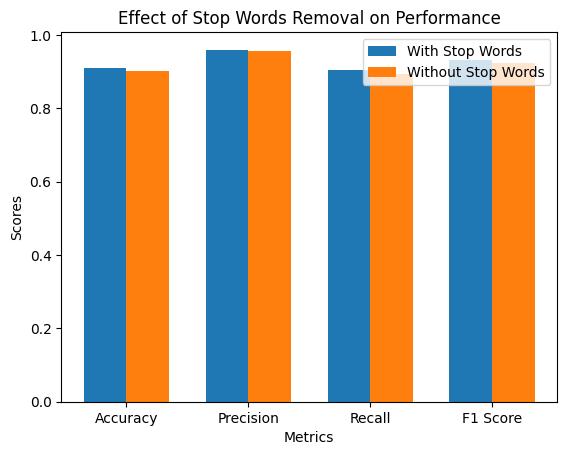



Word Count Threshold Changes

Threshold      Accuracy  Precision Recall    F1        
1000           0.8516    0.9452    0.8278    0.8826    
100            0.8107    0.8965    0.8129    0.8527    
50             0.7790    0.8500    0.8161    0.8327    


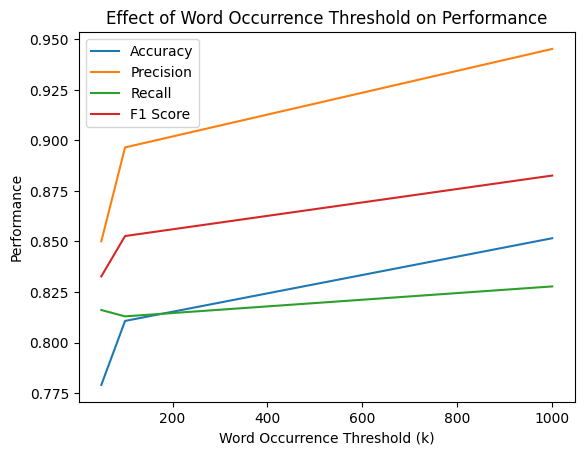



Lambda Smoothing Changes

Lambda    Accuracy  Precision Recall    F1        
2.0       0.9104    0.9603    0.9044    0.9316    
1.0       0.9110    0.9603    0.9053    0.9320    
0.5       0.9123    0.9604    0.9073    0.9331    
0.1       0.9139    0.9599    0.9103    0.9345    
0.005     0.9162    0.9596    0.9141    0.9363    


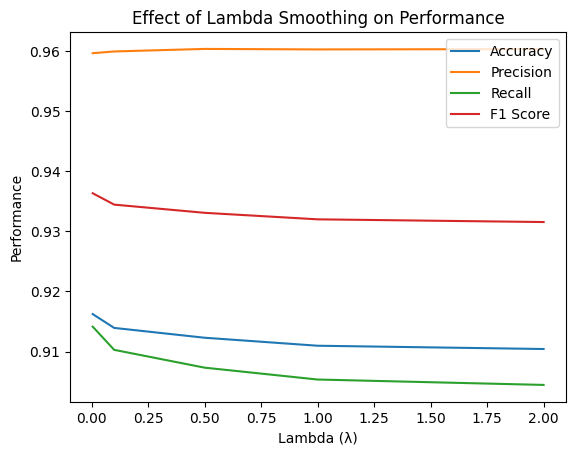

In [ ]:



def experiment_stop_words(train_emails, train_labels, test_emails, test_labels, stop_words):
    # With stop words
    vocabulary_with_stop_words, ham_likelihood_with, spam_likelihood_with, prior_ham_with, prior_spam_with = train_naive_bayes(train_emails, train_labels, stop_words, alpha=1.0)
    y_pred_with = test_naive_bayes(test_emails, vocabulary_with_stop_words, ham_likelihood_with, spam_likelihood_with, prior_ham_with, prior_spam_with, stop_words)
    accuracy_with, precision_with, recall_with, f1_with = evaluate_classifier(test_labels, y_pred_with)

    # Without stop words
    vocabulary_without_stop_words, ham_likelihood_without, spam_likelihood_without, prior_ham_without, prior_spam_without = train_naive_bayes(train_emails, train_labels, [], alpha=1.0)
    y_pred_without = test_naive_bayes(test_emails, vocabulary_without_stop_words, ham_likelihood_without, spam_likelihood_without, prior_ham_without, prior_spam_without, [])
    accuracy_without, precision_without, recall_without, f1_without = evaluate_classifier(test_labels, y_pred_without)

    # Show results in a table or plot
    print("\nEffect of Stop Words Removal on Performance:")
    print(f"{'Metric':<15}{'With Stop Words':<20}{'Without Stop Words':<20}")
    print(f"{'Accuracy':<15}{accuracy_with:<20.4f}{accuracy_without:<20.4f}")
    print(f"{'Precision':<15}{precision_with:<20.4f}{precision_without:<20.4f}")
    print(f"{'Recall':<15}{recall_with:<20.4f}{recall_without:<20.4f}")
    print(f"{'F1 Score':<15}{f1_with:<20.4f}{f1_without:<20.4f}")

    # Show results as a bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    with_stop_words = [accuracy_with, precision_with, recall_with, f1_with]
    without_stop_words = [accuracy_without, precision_without, recall_without, f1_without]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, with_stop_words, width, label='With Stop Words')
    plt.bar(x + width/2, without_stop_words, width, label='Without Stop Words')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Effect of Stop Words Removal on Performance')
    plt.xticks(x, metrics)
    plt.legend(loc='best')
    plt.show()

def experiment_word_count_threshold(train_emails, train_labels, test_emails, test_labels, stop_words):
    thresholds = [1000, 100, 50]  # k > 1000, 100, 50
    results = []
    print('\n\nWord Count Threshold Changes')
    for threshold in thresholds:
        vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(train_emails, train_labels, stop_words, top_n_words=threshold)
        y_pred = test_naive_bayes(test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)
        accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)

        results.append((threshold, accuracy, precision, recall, f1))

    # Display results in a table format
    print(f"\n{'Threshold':<15}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1':<10}")
    for result in results:
        print(f"{result[0]:<15}{result[1]:<10.4f}{result[2]:<10.4f}{result[3]:<10.4f}{result[4]:<10.4f}")

    # Plotting results
    thresholds, accuracies, precisions, recalls, f1s = zip(*results)

    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1 Score')

    plt.xlabel('Word Occurrence Threshold (k)')
    plt.ylabel('Performance')
    plt.title('Effect of Word Occurrence Threshold on Performance')
    plt.legend(loc='best')
    plt.show()

def experiment_lambda_smoothing(train_emails, train_labels, test_emails, test_labels, stop_words):
    lambdas = [2.0, 1.0, 0.5, 0.1, 0.005]  # Different values of lambda (α)
    results = []
    print('\n\nLambda Smoothing Changes')
    for alpha in lambdas:
        vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam = train_naive_bayes(train_emails, train_labels, stop_words, alpha=alpha)
        y_pred = test_naive_bayes(test_emails, vocabulary, ham_likelihood, spam_likelihood, prior_ham, prior_spam, stop_words)
        accuracy, precision, recall, f1 = evaluate_classifier(test_labels, y_pred)

        results.append((alpha, accuracy, precision, recall, f1))

    # Display results in a table format
    print(f"\n{'Lambda':<10}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1':<10}")
    for result in results:
        print(f"{result[0]:<10}{result[1]:<10.4f}{result[2]:<10.4f}{result[3]:<10.4f}{result[4]:<10.4f}")

    #  Plotting results
    lambdas, accuracies, precisions, recalls, f1s = zip(*results)

    plt.plot(lambdas, accuracies, label='Accuracy')
    plt.plot(lambdas, precisions, label='Precision')
    plt.plot(lambdas, recalls, label='Recall')
    plt.plot(lambdas, f1s, label='F1 Score')

    plt.xlabel('Lambda (λ)')
    plt.ylabel('Performance')
    plt.title('Effect of Lambda Smoothing on Performance')
    plt.legend(loc='best')
    plt.show()






# Experiment 1: Effect of Stop Words
experiment_stop_words(processed_train_emails, train_labels, processed_test_emails, test_labels, stop_words)

# Experiment 2: Number of Words Used for Training (Word Occurrence Threshold)
experiment_word_count_threshold(processed_train_emails, train_labels, processed_test_emails, test_labels, stop_words)

# Experiment 3: Lambda Smoothing
experiment_lambda_smoothing(processed_train_emails, train_labels, processed_test_emails, test_labels, stop_words)



1. What is the effect of removing stop words in terms of precision, recall, and
accuracy? Show a plot or a table of these results.
It can be seen that the accuracy, precision and recall change with the removal of the stop words. With the presence of stop words, the performance of the model is better. Including more relevant or significant stop words, would further help the model to perform better.

2. Experiment on the number of words used for training. Filter the dictionary to
include only words occurring more than k times (1000 words, then k > 100, and k
= 50 times). For example, the word “offer” appears 150 times, that means that it
will be included in the dictionary.
It can be seen that the performance increases as the word threshold increases. However, increasing the threshold too much might also make it strict for a word to be included in the dictionary which might also negatively affect the model by restricting the words to be checked in the vocabulary.

3. Discuss the results of the different parameters used for Lambda smoothing. Test
it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate
performance metrics for each.
Changing the value of the λ results in  lower F1 Score, Recall, and Accuracy but increases the precision. In this context, it is better to increase the λ since it is better to let false positives as a ham rather than marking a false negatives as spam.

4. What are your recommendations to further improve the model?
Based on my limited knowledge the models the improvements that I could think of would be including more minority samples or generate spams to increase the robustness of the model. In the context of the model, the stop words were effective but in the context of minority samples, it may need some adjustments as well as improvement such as considering the context of the email. Metadata such as the sender, subject, email length, attachments, and keywords can help identify spam.  